# Module 5: Revealing representative "typical" day-types using traffic data observation and clustering

Exercise related to material in [AH2179-Exercise 5](https://github.com/zhenliangma/Applied-AI-in-Transportation/tree/main/Exercise_5_Clustering).

## Data preparation & preparation

In [45]:
import pandas as pd
import numpy as np
import datetime
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
import sklearn.metrics.pairwise as dis_lib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import random

In [31]:
nintvals = 288 # num of 5-min intervals
def process_and_vectorize_data(path):
  data_df = pd.read_csv(path, sep=';')
  data_df.sort_values(["Date", "Interval_5"])
  days = np.unique(data_df[['Date']].values.ravel())
  ndays = len(days)

  day_subsets_df = data_df.groupby(["Date"])
  vectorized_day_dataset = np.zeros((ndays, nintvals))
  vectorized_day_dataset.fill(np.nan)

  for i in range(0, ndays):
      df_t = day_subsets_df.get_group(days[i])

      for j in range(len(df_t)):
          vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

  return vectorized_day_dataset, days, ndays

vectorized_day_dataset, days, ndays = process_and_vectorize_data("dataset_exercise_5_clustering_highway_traffic.csv")
vectorized_day_dataset_eval, days_eval, ndays_eval = process_and_vectorize_data("evaluation_dataset_exercise_5_clustering_highway_traffic.csv")

# Missing values within training dataset
print('Number of NaNs:', np.sum(np.isnan(vectorized_day_dataset)))
print('Rate of NaNs:', np.sum(np.isnan(vectorized_day_dataset)) / (ndays * nintvals))
nans_per_day = np.sum(np.isnan(vectorized_day_dataset), 1)
print('Number of days with missing values:', np.size(np.where(nans_per_day > 0)))
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0], :]
days_not_nans = days[np.where(nans_per_day == 0)[0]]
print('Final number of days in evaluation dataset:', len(days_not_nans))
print('List of days without missing values:', days_not_nans)
ndays_not_nans = len(days_not_nans)

print('\n Evaluation dataset:')

# Missing values within evaluation dataset
print('Number of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)))
print('Rate of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)) / (ndays_eval * nintvals))
nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval), 1)
print('Number of days with missing values:', np.size(np.where(nans_per_day_eval > 0)))
vectorized_day_dataset_no_nans_eval = vectorized_day_dataset_eval[np.where(nans_per_day_eval == 0)[0], :]
days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]
print('Final number of days in evaluation dataset:', len(days_not_nans_eval))
print('List of days without missing values:', days_not_nans_eval)
ndays_eval_not_nans = len(days_not_nans_eval)

Number of NaNs: 277
Rate of NaNs: 0.0026350837138508373
Number of days with missing values: 28
Final number of days in evaluation dataset: 337
List of days without missing values: [20210101 20210102 20210103 20210104 20210105 20210106 20210107 20210108
 20210109 20210110 20210111 20210112 20210113 20210114 20210115 20210116
 20210117 20210118 20210119 20210120 20210121 20210122 20210123 20210124
 20210125 20210127 20210128 20210129 20210130 20210131 20210201 20210202
 20210203 20210204 20210205 20210206 20210207 20210208 20210209 20210210
 20210211 20210212 20210213 20210214 20210215 20210216 20210217 20210218
 20210220 20210221 20210223 20210224 20210225 20210226 20210227 20210228
 20210301 20210302 20210303 20210304 20210305 20210306 20210307 20210308
 20210309 20210310 20210311 20210312 20210313 20210314 20210315 20210316
 20210317 20210318 20210319 20210320 20210321 20210322 20210323 20210324
 20210325 20210326 20210327 20210331 20210401 20210402 20210403 20210404
 20210405 2021040

In [32]:
# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid

In [33]:
def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')


    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()

In [34]:
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, nintvals):
  x_axis_hours.append(float(np.arange(0, nintvals, 1, dtype=int)[i]*5)/60)

### Model and Parameter Iterations

kmean model:
cluster_id_weekdays_share [76, 133, 21, 6]
cluster_id_weekend_share [0, 0, 50, 51]
111


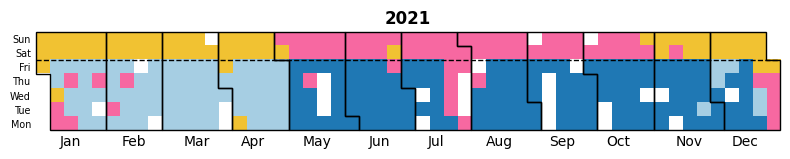

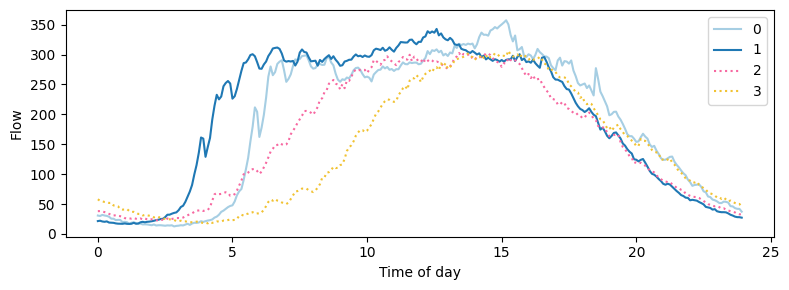

agglo model:
cluster_id_weekdays_share [102, 128, 6]
cluster_id_weekend_share [55, 0, 46]
111


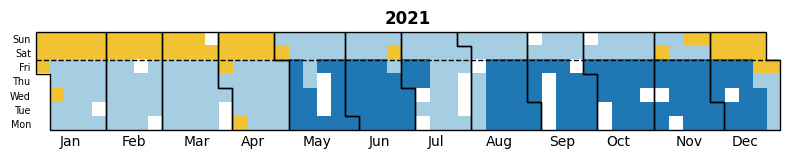

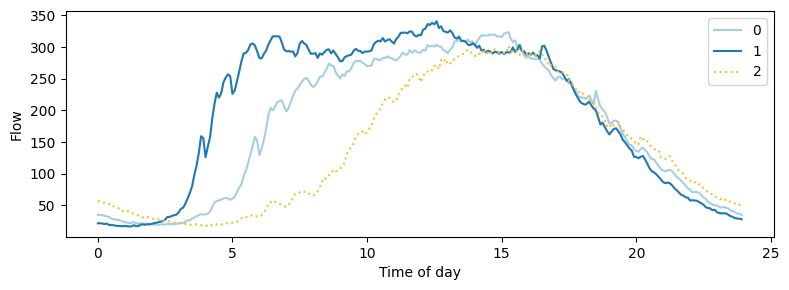

gmm model:
cluster_id_weekdays_share [74, 9, 6, 86, 1, 60]
cluster_id_weekend_share [0, 56, 43, 0, 2, 0]
111


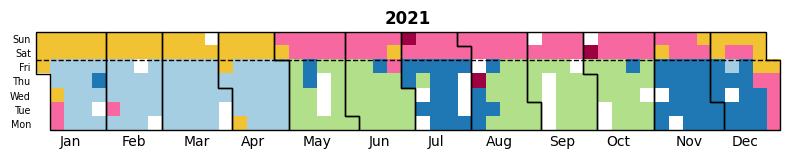

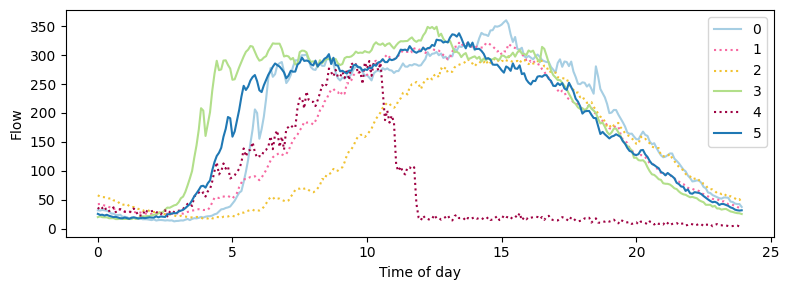

kmean model:
cluster_id_weekdays_share [133, 6, 76, 21]
cluster_id_weekend_share [0, 51, 0, 50]
111


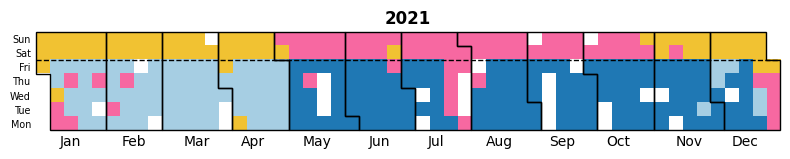

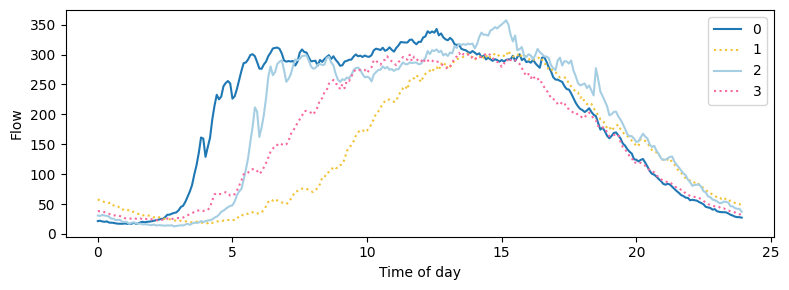

agglo model:
cluster_id_weekdays_share [6, 25, 90, 71, 1, 5, 5, 33]
cluster_id_weekend_share [46, 11, 0, 0, 2, 0, 42, 0]
111


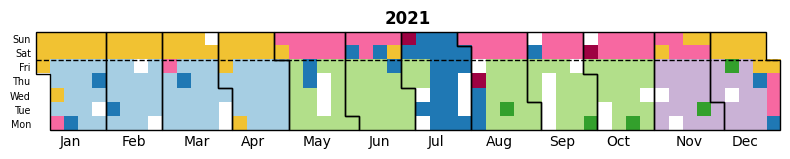

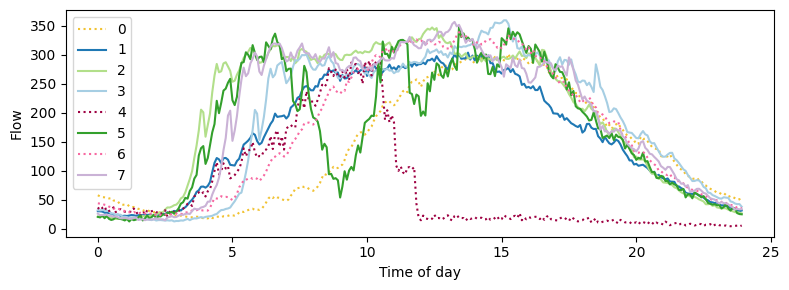

gmm model:
cluster_id_weekdays_share [8, 28, 6, 52, 1, 83, 30, 28, 0]
cluster_id_weekend_share [28, 0, 38, 0, 2, 0, 0, 0, 33]
111


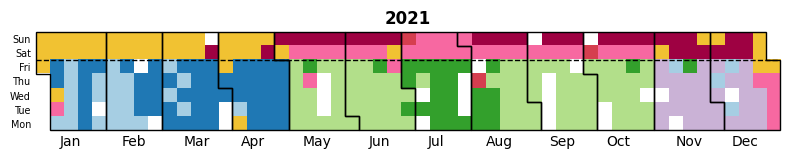

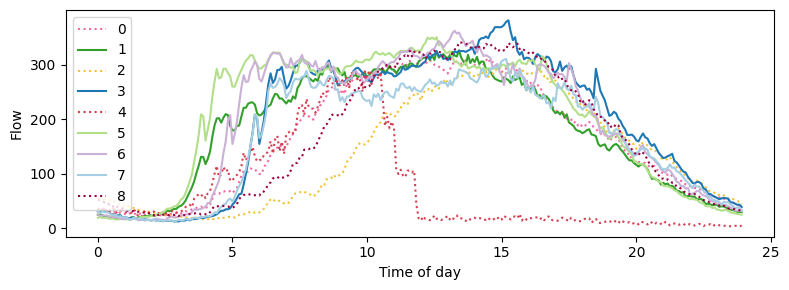

kmean model:
cluster_id_weekdays_share [2, 92, 6, 76, 53, 7]
cluster_id_weekend_share [2, 0, 42, 0, 0, 57]
111


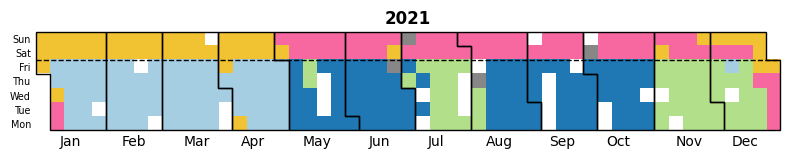

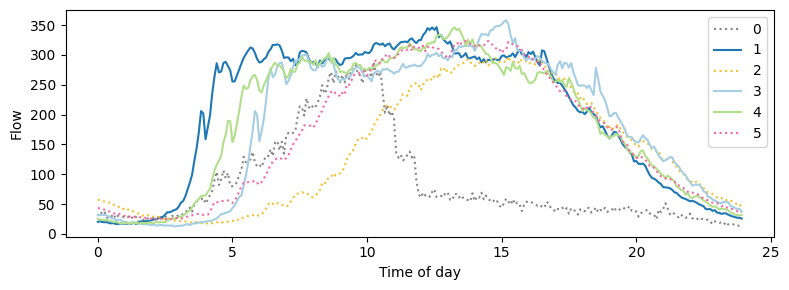

agglo model:
cluster_id_weekdays_share [228, 1, 7]
cluster_id_weekend_share [61, 2, 38]
111


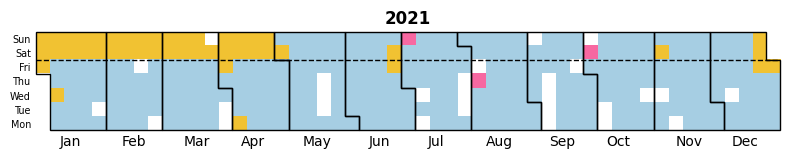

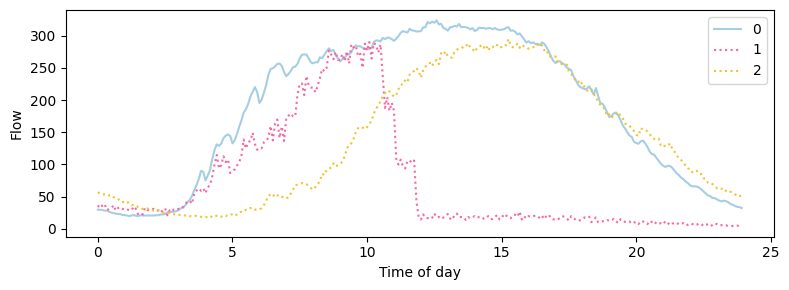

gmm model:
cluster_id_weekdays_share [85, 77, 2, 60, 6, 6]
cluster_id_weekend_share [0, 0, 2, 0, 43, 56]
111


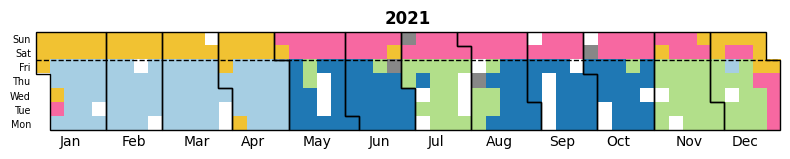

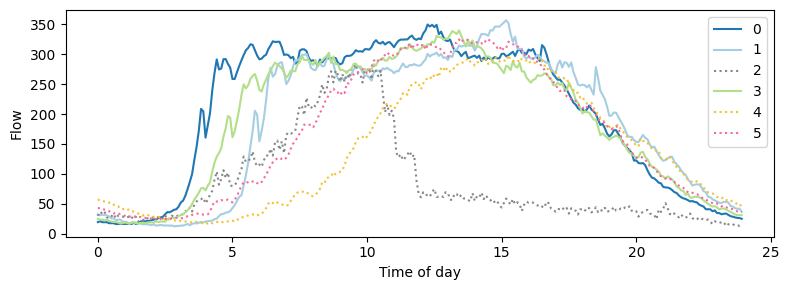

kmean model:
cluster_id_weekdays_share [6, 134, 21, 75]
cluster_id_weekend_share [51, 0, 50, 0]
111


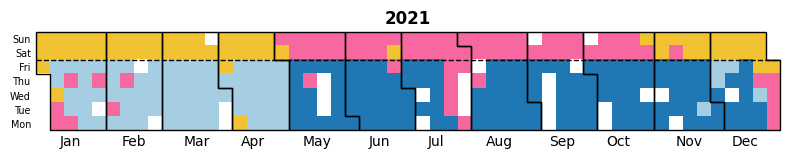

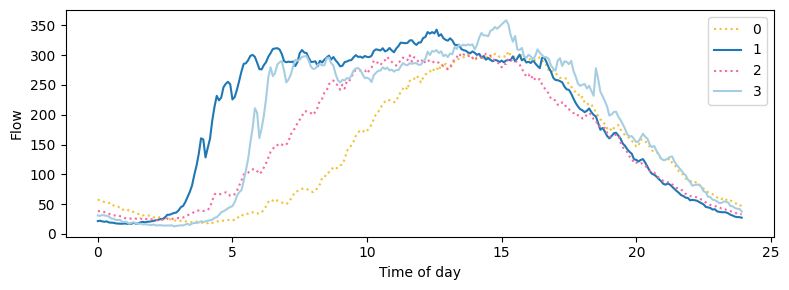

agglo model:
cluster_id_weekdays_share [4, 1, 221, 1, 1, 1, 6, 1]
cluster_id_weekend_share [0, 2, 47, 0, 0, 0, 52, 0]
111


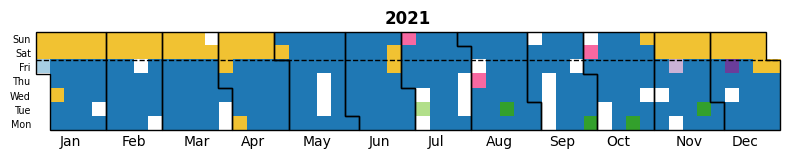

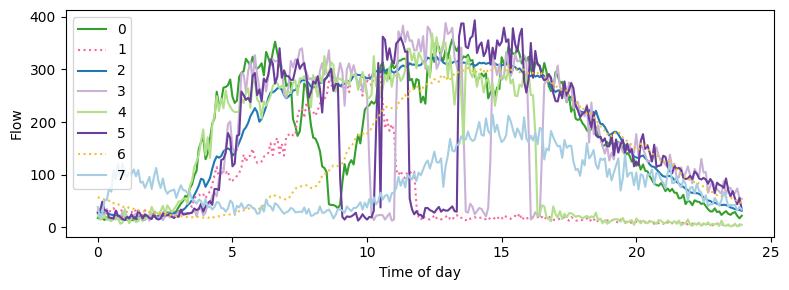

gmm model:
cluster_id_weekdays_share [93, 77, 6, 6, 2, 52]
cluster_id_weekend_share [0, 0, 42, 57, 2, 0]
111


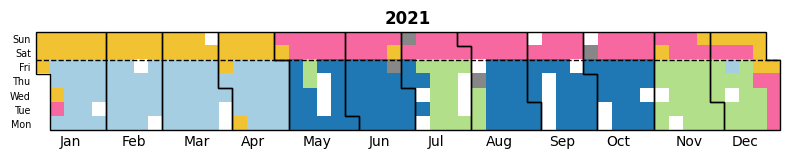

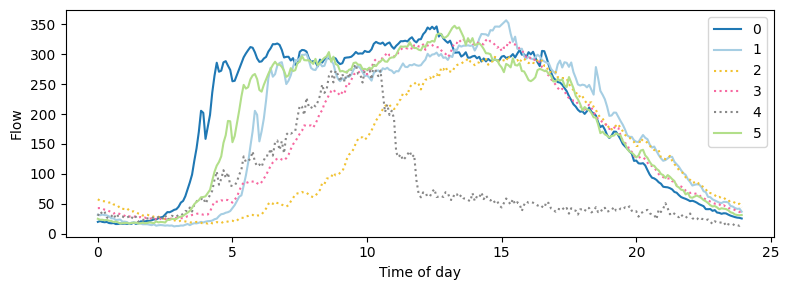

,Model,#Clusters,Parameters,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score,MAE,MAPE
0,{kmean},4,"{'n_clusters': 4, 'n_init': 3}",0.265657,1.459969,132.989853,29.796161,0.390579
1,{agglo},3,"{'n_clusters': 3, 'metric': 'euclidean', 'link...",0.268112,1.313811,148.607605,30.988773,0.417042
2,{gmm},6,{'n_components': 6},0.238688,1.455240,115.241286,26.028140,0.259945
3,{kmean},4,"{'n_clusters': 4, 'n_init': 6}",0.265657,1.459969,132.989853,29.796161,0.390579
4,{agglo},8,"{'n_clusters': 8, 'metric': 'euclidean', 'link...",0.239635,1.440534,91.736572,24.801210,0.239612
5,{gmm},9,{'n_components': 9},0.195654,1.630777,87.183552,24.965659,0.246586
6,{kmean},6,"{'n_clusters': 6, 'n_init': 3}",0.235752,1.476993,114.824772,25.853670,0.272402
7,{agglo},3,"{'n_clusters': 3, 'metric': 'manhattan', 'link...",0.316356,0.808634,72.668254,35.599419,0.338982
8,{gmm},6,{'n_components': 6},0.235099,1.488245,114.728769,26.010913,0.276964
9,{kmean},4,"{'n_clusters': 4, 'n_init': 4}",0.266616,1.456857,132.989258,29.828105,0.390680


In [54]:
models = [
    ('kmean', KMeans()),
    ('agglo', AgglomerativeClustering()),
    ('gmm', GaussianMixture())]

params = {
    'kmean': {
        'n_clusters': np.random.randint(3, 10, size=4),
        'n_init': np.random.randint(1, 10, size=4)
    },
    'agglo': {
        'n_clusters': np.random.randint(3, 10, size=4),
        'metric': ['euclidean', 'manhattan', 'cosine'],
        'linkage': ['ward', 'complete', 'average', 'single']
    },
    'gmm': {
        'n_components': np.random.randint(3, 10, size=4),
    }}

# output df
output_df = pd.DataFrame(columns=['Model', '#Clusters', 'Parameters', 'Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score', 'MAE', 'MAPE'])

# iterate through models
for iter in range(4):
  for name, model in models:
      print(f"{name} model:")

      # Sample random parameters for the current model
      sampled_params = dict()
      for param, dist in params[name].items():
        sampled_params[param] = random.choice(dist)

      if name == 'agglo' and sampled_params['linkage'] == 'ward':
        sampled_params['metric'] = 'euclidean' # ward linkage only works with euclidean

      model.set_params(**sampled_params)


      # define pipeline
      pipeline = Pipeline([('cluster', model)])
      pipeline.fit(vectorized_day_dataset_no_nans)


      # get labels
      if name == 'gmm':
          cluster_labels = pipeline['cluster'].predict(vectorized_day_dataset_no_nans)
      else:
          cluster_labels = pipeline['cluster'].labels_

          # labels are sometimes negative
          if name == 'dbscan' and np.min(cluster_labels) < 0:
              cluster_labels = cluster_labels - np.min(cluster_labels)

      # Calculate the Silhouette Score
      SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
      DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
      CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)

      # calendar vis
      n_clusters_t = len(np.unique(cluster_labels))
      days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
      make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                        color_to_cluster, save_figure=None)

      centroids_xx = []
      centroids_yy_daytypes = []
      cluster_ids = []

      # Iterate through each cluster
      for i in range(0, n_clusters_t):
          # Store the x-axis values for centroids (hours of the day)
          centroids_xx.append(x_axis_hours)

          # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
          centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
          centroids_yy_daytypes.append(centroid_yy)

          # Store the cluster ID
          cluster_ids.append(i)

      # Generate a figure displaying the centroids
      make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)

      # Initialize a list to store centroid data
      centroids = []
      for i in range(0, n_clusters_t):
          centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
          centroids.append(centroid)

      n_past_intervals_for_classification = 5
      total_mae = 0
      total_mape = 0
      prediction_counts = 0

      # Loop through each day in the evaluation dataset with no missing values
      for i in range(0, ndays_eval_not_nans):
          for j in range(n_past_intervals_for_classification, nintvals - 1):
              centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)
              predicted_value = centroids[centroid_index][0, j + 1]
              mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
              mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])
              total_mae += mae_t
              total_mape += mape_t
              prediction_counts += 1



      output_df.loc[len(output_df)] = [
          {name},
          n_clusters_t, # number of clusters
          sampled_params,
          SC_score,
          DB_score,
          CH_score,
          total_mae / prediction_counts, # MAE
          total_mape / prediction_counts #MAPE
          ]

output_df

289


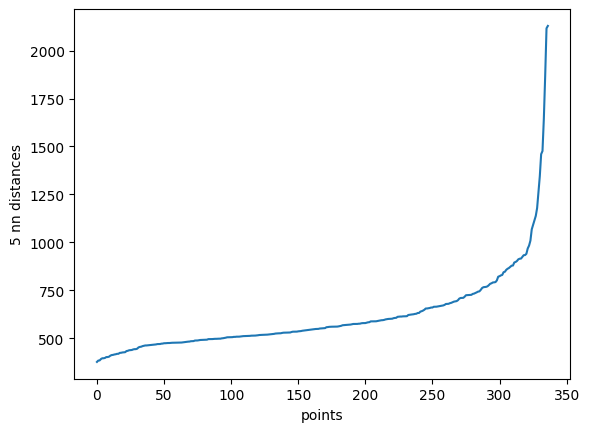

In [68]:
# find the knee of 5nn distances of all points
from sklearn.neighbors import NearestNeighbors

# dims + 1
minPoints = vectorized_day_dataset_no_nans.shape[1]  + 1
print(minPoints)

nbrs = NearestNeighbors(n_neighbors=5).fit(vectorized_day_dataset_no_nans)
distances, indices = nbrs.kneighbors(vectorized_day_dataset_no_nans)

sorted_distances = np.sort(distances[:, 4])

plt.plot(sorted_distances)
plt.ylabel('5 nn distances')
plt.xlabel('points')
plt.show()

[0 1 1 0 2 1 2 2 1 1 0 0 0 0 0 1 1 2 0 2 2 2 1 1 0 0 0 2 1 1 0 0 0 0 0 1 1
 2 2 2 0 2 1 1 2 2 2 0 1 1 2 0 0 0 1 1 2 2 0 2 0 1 1 2 0 2 0 2 1 1 2 2 2 0
 2 1 1 2 0 0 0 2 1 0 0 0 1 1 1 0 2 2 0 1 1 0 2 2 0 2 1 1 2 0 2 2 0 1 1 0 2
 0 0 0 1 3 4 4 4 0 0 3 3 0 0 0 0 5 3 3 0 0 3 3 0 4 4 4 0 3 3 0 0 0 4 0 0 3
 4 4 0 0 0 0 3 0 0 4 4 0 3 3 4 0 0 4 0 0 3 0 0 0 0 0 3 0 0 0 5 3 3 5 5 0 5
 5 3 3 5 0 5 5 5 3 3 5 0 3 3 5 0 5 0 3 3 0 0 0 5 0 0 3 4 0 0 0 0 3 0 0 4 0
 0 0 0 3 4 4 4 0 0 0 4 3 3 4 4 0 4 0 3 3 4 4 0 0 0 3 0 0 4 0 0 0 0 0 4 0 0
 0 0 4 4 0 0 0 0 4 4 0 0 3 0 0 0 4 4 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 6 0 0 0 0 1 0 0 0 0 0 1 1 6 6 0 0 0 1 1 0 0 0 0 0 0 1 0
 3 3 3 0]
cluster_id_weekdays_share [145, 2, 37, 3, 32, 14, 3]
cluster_id_weekend_share [22, 44, 0, 35, 0, 0, 0]
111


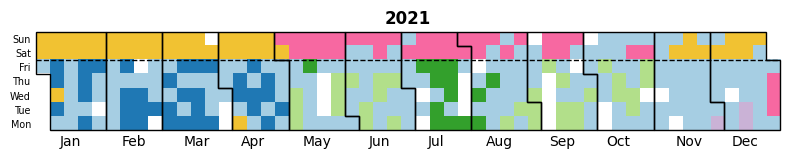

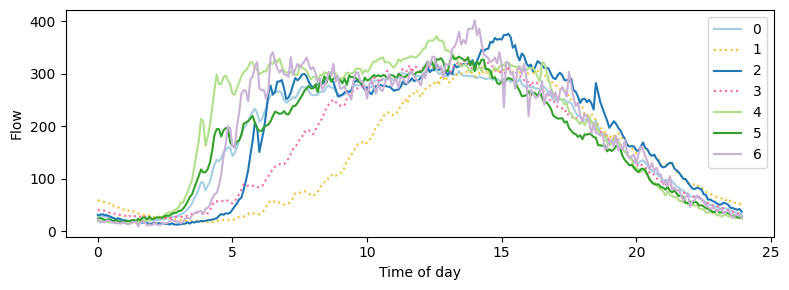

[0 1 1 0 2 1 2 2 1 1 0 0 0 0 0 1 1 2 0 2 2 2 1 1 0 0 0 2 1 1 0 0 0 0 0 1 1
 2 2 2 0 2 1 1 2 2 2 0 1 1 2 0 0 0 1 1 2 2 0 2 0 1 1 2 0 2 0 2 1 1 2 2 2 0
 2 1 1 2 0 0 0 2 1 0 0 0 1 1 1 0 2 2 0 1 1 0 2 2 0 2 1 1 2 0 2 2 0 1 1 0 2
 0 0 0 1 3 4 4 4 0 0 3 3 0 0 0 0 5 3 3 0 0 3 3 0 4 4 4 0 3 3 0 0 0 4 0 0 3
 4 4 0 0 0 0 3 0 0 4 4 0 3 3 4 0 0 4 0 0 3 0 0 0 0 0 3 0 0 0 5 3 3 5 5 0 5
 5 3 3 5 0 5 5 5 3 3 5 0 3 3 5 0 5 0 3 3 0 0 0 5 0 0 3 4 0 0 0 0 3 0 0 4 0
 0 0 0 3 4 4 4 0 0 0 4 3 3 4 4 0 4 0 3 3 4 4 0 0 0 3 0 0 4 0 0 0 0 0 4 0 0
 0 0 4 4 0 0 0 0 4 4 0 0 3 0 0 0 4 4 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 6 0 0 0 0 1 0 0 0 0 0 1 1 6 6 0 0 0 1 1 0 0 0 0 0 0 1 0
 3 3 3 0]
cluster_id_weekdays_share [145, 2, 37, 3, 32, 14, 3]
cluster_id_weekend_share [22, 44, 0, 35, 0, 0, 0]
111


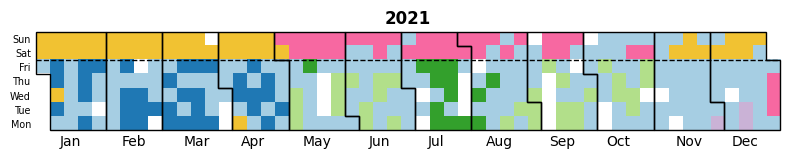

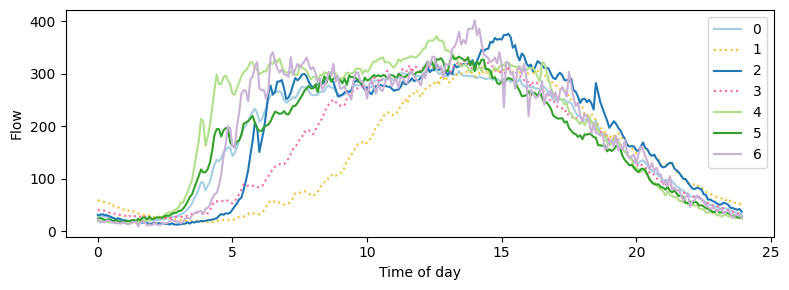

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
cluster_id_weekdays_share [23, 211, 2]
cluster_id_weekend_share [3, 98, 0]
111


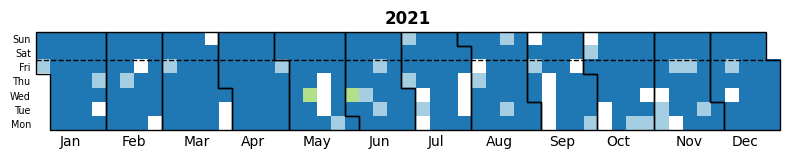

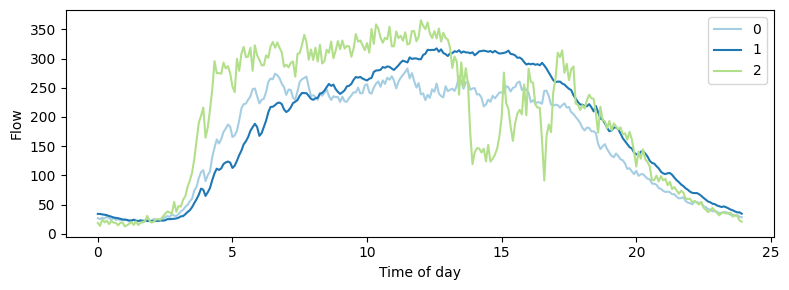

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
cluster_id_weekdays_share [25, 211]
cluster_id_weekend_share [3, 98]
111


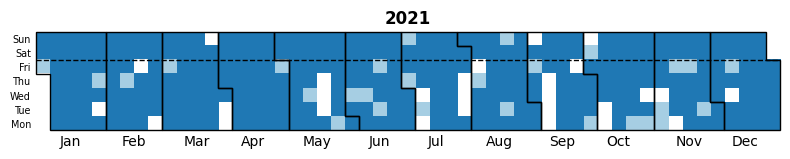

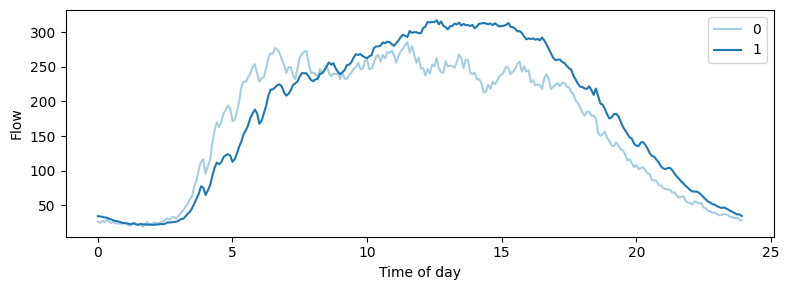

In [66]:
eps_vals = [500, 800]
minpoint_vals = [2, 3]

for eps_val in eps_vals:
    for minpoint_val in minpoint_vals:
        db_clusters = DBSCAN(eps=eps_val, min_samples = minpoint_val).fit(vectorized_day_dataset_no_nans)

        cluster_labels = db_clusters.labels_

        # labels are sometimes negative
        if np.min(cluster_labels) < 0:
            cluster_labels = cluster_labels - np.min(cluster_labels)

        print(cluster_labels)

        # Calculate the Silhouette Score
        SC_score = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
        DB_score = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
        CH_score = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)

        # calendar vis
        n_clusters_t = len(np.unique(cluster_labels))
        days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
        make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                          color_to_cluster, save_figure=None)

        centroids_xx = []
        centroids_yy_daytypes = []
        cluster_ids = []

        # Iterate through each cluster
        for i in range(0, n_clusters_t):
            # Store the x-axis values for centroids (hours of the day)
            centroids_xx.append(x_axis_hours)

            # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
            centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
            centroids_yy_daytypes.append(centroid_yy)

            # Store the cluster ID
            cluster_ids.append(i)

        # Generate a figure displaying the centroids
        make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)

        # Initialize a list to store centroid data
        centroids = []
        for i in range(0, n_clusters_t):
            centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
            centroids.append(centroid)

        n_past_intervals_for_classification = 5
        total_mae = 0
        total_mape = 0
        prediction_counts = 0

        # Loop through each day in the evaluation dataset with no missing values
        for i in range(0, ndays_eval_not_nans):
            for j in range(n_past_intervals_for_classification, nintvals - 1):
                centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)
                predicted_value = centroids[centroid_index][0, j + 1]
                mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
                mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])
                total_mae += mae_t
                total_mape += mape_t
                prediction_counts += 1

        output_df.loc[len(output_df)] = [
            'dbscan',
            n_clusters_t, # number of clusters
            'minPoints: ' + str(minpoint_val) + ', eps: ' + str(eps_val),
            SC_score,
            DB_score,
            CH_score,
            total_mae / prediction_counts, # MAE
            total_mape / prediction_counts #MAPE
            ]



### Evaluation Metrics

In [75]:
output_df.sort_values(by=['Calinski-Harabasz Score', 'MAE', 'MAPE'], ascending=[False, True, True])

,Model,#Clusters,Parameters,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score,MAE,MAPE
1,{agglo},3,"{'n_clusters': 3, 'metric': 'euclidean', 'link...",0.268112,1.313811,148.607605,30.988773,0.417042
0,{kmean},4,"{'n_clusters': 4, 'n_init': 3}",0.265657,1.459969,132.989853,29.796161,0.390579
3,{kmean},4,"{'n_clusters': 4, 'n_init': 6}",0.265657,1.459969,132.989853,29.796161,0.390579
9,{kmean},4,"{'n_clusters': 4, 'n_init': 4}",0.266616,1.456857,132.989258,29.828105,0.390680
2,{gmm},6,{'n_components': 6},0.238688,1.455240,115.241286,26.028140,0.259945
6,{kmean},6,"{'n_clusters': 6, 'n_init': 3}",0.235752,1.476993,114.824772,25.853670,0.272402
11,{gmm},6,{'n_components': 6},0.234354,1.473278,114.782695,25.777079,0.271515
8,{gmm},6,{'n_components': 6},0.235099,1.488245,114.728769,26.010913,0.276964
4,{agglo},8,"{'n_clusters': 8, 'metric': 'euclidean', 'link...",0.239635,1.440534,91.736572,24.801210,0.239612
5,{gmm},9,{'n_components': 9},0.195654,1.630777,87.183552,24.965659,0.246586
